<a href="https://colab.research.google.com/github/marzione00/7a34747f/blob/master/contento9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras import layers
import pathlib
from tensorflow import keras

root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


data_dir = tf.keras.utils.get_file(origin="https://www.dropbox.com/s/9pm18i62bxfwswp/TRAINING.tar?dl=1", 
                                   fname='TRAINING', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

data_Y = tf.keras.utils.get_file(origin="https://www.dropbox.com/s/q8lg83of5kzozol/TEST.tar?dl=1", 
                                   fname='TEST', 
                                   untar=True)

data_Y = pathlib.Path(data_Y)
image_count_testY = len(list(data_Y.glob('*/*.jpg')))
print(image_count_testY)




data_X = tf.keras.utils.get_file(origin="https://www.dropbox.com/s/w92vbi3ysfg0tk4/test-multiple_fruitsX.tar?dl=1", 
                                   fname='test-multiple_fruits', 
                                   untar=True)

data_X = pathlib.Path(data_X)
image_count_testX = len(list(data_X.glob('*/*.jpg')))
print(image_count_testX)


159039488/159031808 [==============================] - 1s 0us/step
30747
53428224/53423104 [==============================] - 0s 0us/step
10454
377675776/377673728 [==============================] - 6s 0us/step
103


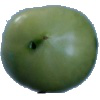

In [2]:
Banana = list(data_dir.glob('Banana/*'))
PIL.Image.open(str(Banana[10]))
Apple = list(data_dir.glob('Apple/*'))
PIL.Image.open(str(Apple[10]))
Potato = list(data_dir.glob('Potato/*'))
PIL.Image.open(str(Potato[10]))
Cherry = list(data_dir.glob('Cherry/*'))
PIL.Image.open(str(Cherry[10]))
Tomato = list(data_dir.glob('Tomato/*'))
PIL.Image.open(str(Tomato[10]))





In [3]:
batch_size = 32
img_height = 32
img_width = 32

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  label_mode='categorical',
  seed=123,
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 30747 files belonging to 10 classes.
Using 24598 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  label_mode='categorical',
  seed=123,
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 30747 files belonging to 10 classes.
Using 6149 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Apple', 'Banana', 'Cherry', 'Grape', 'Peach', 'Pear', 'Pepper', 'Plum', 'Potato', 'Tomato']


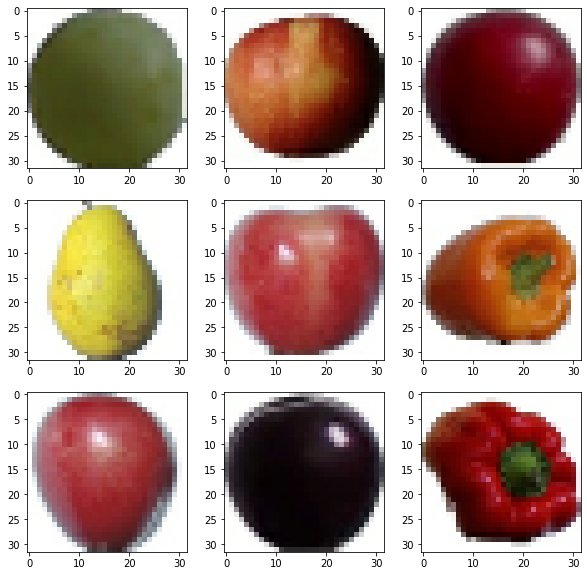

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

In [11]:
#####LUNGO DA ESEGUIRE###########

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3):
    model_prod = keras.models.Sequential()

    model_prod.add(layers.experimental.preprocessing.Rescaling(1./32, input_shape=(32, 32, 3)))
    model_prod.add(keras.layers.Flatten())
    for layer in range(n_hidden):
        model_prod.add(keras.layers.Dense(n_neurons, activation="relu"))
    model_prod.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model_prod.compile(loss="categorical_crossentropy", metrics=["accuracy"],optimizer='adam')
    return model_prod

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

param_distribs = {
    "n_hidden": [4,5,6,7,8,9,10],
    "n_neurons": [80,120, 160,200,240,280, 320,360,400],
    "learning_rate": [3e-3,3e-4,3e-2]
}

res = list(zip(*train_ds.unbatch().as_numpy_iterator()))
x_train = np.array(res[0])

y_train = np.array(res[1])

print(x_train.shape,y_train.shape)

resx = list(zip(*val_ds.unbatch().as_numpy_iterator()))
x_val = np.array(resx[0])

y_val = np.array(resx[1])

print(x_val.shape,y_val.shape)

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=4)



rnd_search_cv.fit(x_train,y_train,epochs=20,validation_data=(x_val, y_val))

print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)

model=rnd_search_cv.best_estimator_.model



#print(rnd_search_cv.best_params_)
#print(rnd_search_cv.best_score_)
#model=rnd_search_cv.best_estimator_.model
#model.save("peppo.h5")

(24598, 32, 32, 3) (24598, 10)
(6149, 32, 32, 3) (6149, 10)
Epoch 1/20
577/577 [==============================] - 9s 14ms/step - loss: 1.4070 - accuracy: 0.5188 - val_loss: 0.4187 - val_accuracy: 0.8432
Epoch 2/20
577/577 [==============================] - 8s 14ms/step - loss: 0.3553 - accuracy: 0.8786 - val_loss: 0.3102 - val_accuracy: 0.9031
Epoch 3/20
577/577 [==============================] - 8s 14ms/step - loss: 0.2489 - accuracy: 0.9213 - val_loss: 0.0969 - val_accuracy: 0.9628
Epoch 4/20
577/577 [==============================] - 8s 14ms/step - loss: 0.1345 - accuracy: 0.9597 - val_loss: 0.1866 - val_accuracy: 0.9471
Epoch 5/20
577/577 [==============================] - 8s 14ms/step - loss: 0.1269 - accuracy: 0.9607 - val_loss: 0.0971 - val_accuracy: 0.9743
Epoch 6/20
398/577 [===================>..........] - ETA: 2s - loss: 0.1225 - accuracy: 0.9627

KeyboardInterrupt: ignored

In [ ]:
num_classes = 10

model = tf.keras.Sequential([
        layers.experimental.preprocessing.Rescaling(1./32, input_shape=(img_height, img_width, 3)),
        layers.Flatten(),                
        layers.Dense(60, activation="relu", name="layer1"),
        layers.Dense(60, activation="relu", name="layer2"),
        layers.Dense(60, activation="relu", name="layer3"),
        layers.Dense(60, activation="relu", name="layer4"),
        layers.Dense(60, activation="relu", name="layer5"),
        layers.Dense(60, activation="relu", name="layer6"),
        layers.Dense(10, activation='softmax',name="layer8"),
    
])

model.compile(
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history =model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[keras.callbacks.EarlyStopping(patience=10), tensorboard_cb]
)



Epoch 1/10
769/769 [==============================] - 23s 29ms/step - loss: 1.6192 - accuracy: 0.4436 - val_loss: 1.1728 - val_accuracy: 0.6543
Epoch 2/10
769/769 [==============================] - 18s 23ms/step - loss: 0.4380 - accuracy: 0.8501 - val_loss: 0.1497 - val_accuracy: 0.9455
Epoch 3/10
769/769 [==============================] - 18s 23ms/step - loss: 0.2451 - accuracy: 0.9191 - val_loss: 0.0840 - val_accuracy: 0.9737
Epoch 4/10
769/769 [==============================] - 18s 24ms/step - loss: 0.1773 - accuracy: 0.9461 - val_loss: 0.0451 - val_accuracy: 0.9842
Epoch 5/10
769/769 [==============================] - 18s 23ms/step - loss: 0.1648 - accuracy: 0.9509 - val_loss: 1.1192 - val_accuracy: 0.7840
Epoch 6/10
769/769 [==============================] - 18s 23ms/step - loss: 0.1483 - accuracy: 0.9605 - val_loss: 1.7176 - val_accuracy: 0.7474
Epoch 7/10
769/769 [==============================] - 18s 23ms/step - loss: 0.1448 - accuracy: 0.9623 - val_loss: 0.0282 - val_accuracy:

In [ ]:
X_new = Apple[0]

In [ ]:
print(Apple[1])

/root/.keras/datasets/TRAINING/Apple/APPLE_RED_DELICIOUS_r_44_100.jpg


In [ ]:
model.summary()

Model: "sequential_177"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_153 (Rescaling)    (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_175 (Flatten)        (None, 3072)              0         
_________________________________________________________________
layer1 (Dense)               (None, 60)                184380    
_________________________________________________________________
layer2 (Dense)               (None, 60)                3660      
_________________________________________________________________
layer3 (Dense)               (None, 60)                3660      
_________________________________________________________________
layer4 (Dense)               (None, 60)                3660      
_________________________________________________________________
layer5 (Dense)               (None, 60)             

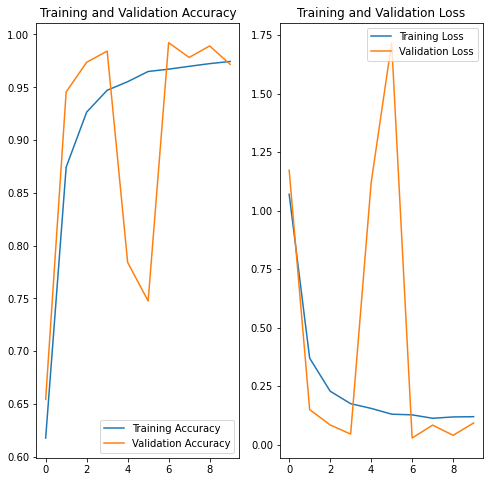

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow import keras
img = keras.preprocessing.image.load_img(str(Cherry[10]), target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array).round(3)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to Cherry with a 23.20 percent confidence.


In [ ]:
model.predict(img_array).round(3)

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)